# Hybrid CNN → Transformer → LSTM

2025-11-11 09:43:07.262367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762854187.492174      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762854187.564594      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-11 09:43:20.318820: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.0651 - loss: 3.0882 - val_accuracy: 0.0852 - val_loss: 2.8538
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1633 - loss: 2.7117 - val_accuracy: 0.3636 - val_loss: 2.1378
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3635 - loss: 2.0005 - val_accuracy: 0.5852 - val_loss: 1.3591
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5826 - loss: 1.3338 - val_accuracy: 0.7131 - val_loss: 1.0014
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6748 - loss: 0.9999 - val_accuracy: 0.7330 - val_loss: 0.9023
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7530 - loss: 0.7843 - val_accuracy: 0.8494 - val_loss: 0.5366
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8263 - loss: 0.5648 - val_accuracy: 0.9318 - val_loss: 0.3502
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8687 - loss: 0.4604 - val_accuracy: 0.

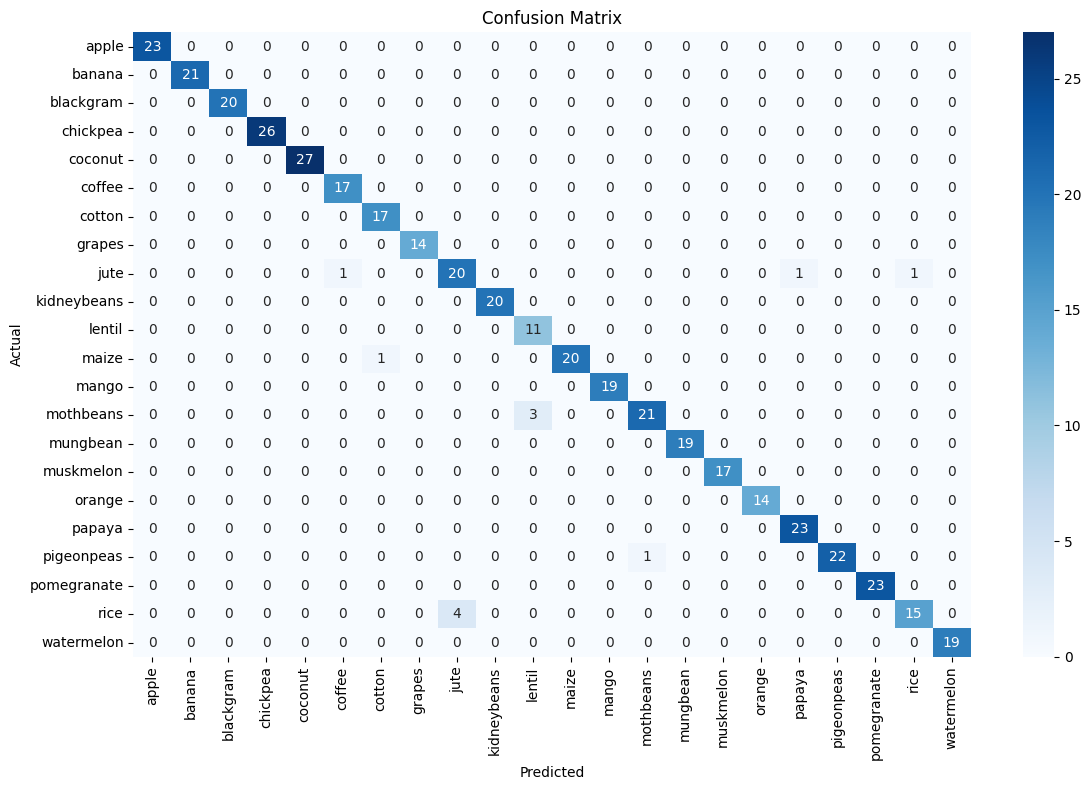

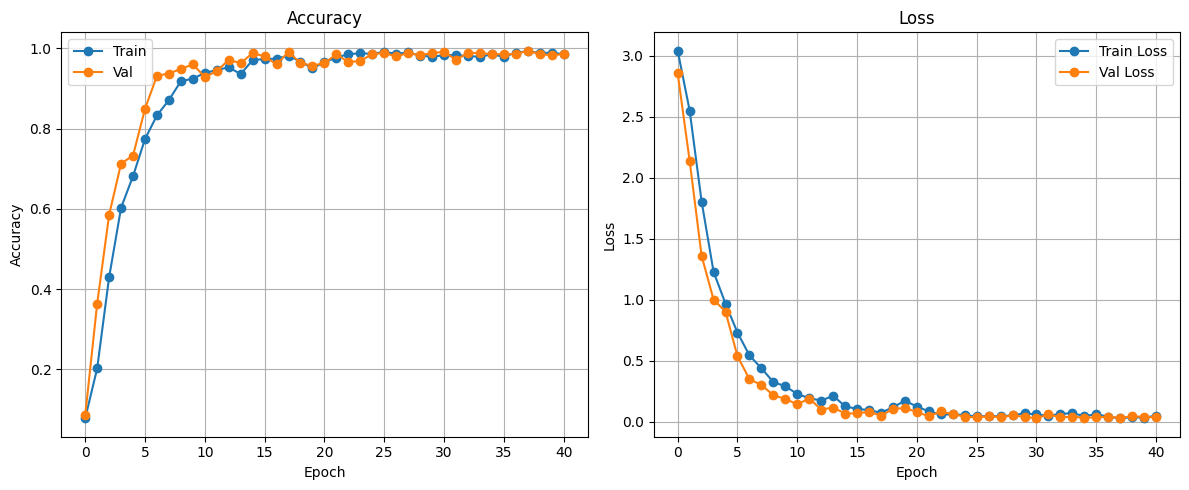

Model saved as 'cnn_transformer_lstm_model.h5'


In [1]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load & preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# 2. Define Model
def hybrid_cnn_transformer_lstm(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128):
    inp = Input(shape=input_shape)

    # CNN Block
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inp)

    # Transformer Block
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # LSTM Block
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Dense Output
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = hybrid_cnn_transformer_lstm(input_shape=(7, 1), num_classes=y_cat.shape[1])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

# 4. Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

model.save('cnn_transformer_lstm_model.h5')
print("Model saved as 'cnn_transformer_lstm_model.h5'")

In [ ]:
# 7. SHAP Explainability
print("🔍 SHAP Explainability:")
X_flat = X_seq.reshape(X_seq.shape[0], X_seq.shape[1])
explainer = shap.KernelExplainer(lambda x: model.predict(x.reshape(x.shape[0], 7, 1)), X_flat[:50])
shap_values = explainer.shap_values(X_flat[:1])
shap.summary_plot(shap_values, X_flat[:1], feature_names=features)

# 8. LIME Explainability
print("🔍 LIME Explainability:")
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_flat,
    feature_names=features,
    class_names=le.classes_,
    mode='classification'
)

lime_exp = explainer_lime.explain_instance(
    data_row=X_flat[0],
    predict_fn=lambda x: model.predict(x.reshape(x.shape[0], 7, 1)),
    num_features=7
)
lime_exp.show_in_notebook()
